In [13]:
import os
import pandas as pd
import numpy as np
import torch as tc
import torch.nn as nn
from tqdm import tqdm
import time
import json
import itertools

# --- Importe suas classes ---
# (Assumindo que estão no PYTHONPATH ou na mesma pasta)
from equation.option_pricing import BlackScholes
from optimize.option_princing import BlackScholeOptimizer
from method.nn import MLP, ResNet
from method.hnn import HybridCQN 
from method.qnn import QuantumNeuralNetwork


In [14]:
# =============================================================================
# FUNÇÕES AUXILIARES
# =============================================================================

def generate_runs(base_config, sweep_params):
    """
    Função auxiliar para gerar uma lista de experimentos (runs).
    
    Ela pega uma 'base_config' (comum a todas as runs) e um 
    'sweep_params' (dicionário com listas de valores para variar)
    e cria todas as combinações.
    """
    generated_experiments = []
    param_keys = sweep_params.keys()
    param_values = sweep_params.values()
    
    for combination in itertools.product(*param_values):
        new_config = base_config.copy()
        param_combination_dict = {}
        run_id_parts = [base_config.get("run_id_prefix", base_config.get("model_type", "run"))]
        
        for key, value in zip(param_keys, combination):
            param_combination_dict[key] = value
            
            if isinstance(value, nn.Module):
                val_str = value.__class__.__name__
            else:
                val_str = str(value)
            
            key_str = key.replace("learning_rate", "lr").replace("hidden", "n").replace("layers", "l").replace("hidden", "h").replace("blocks", "b")
            run_id_parts.append(f"{key_str}_{val_str}")

        new_config.update(param_combination_dict)
        new_config["run_id"] = "_".join(run_id_parts)
        generated_experiments.append(new_config)
        
    return generated_experiments

def pretty_print(config_list, num_to_show=5):
    """Função para imprimir a grade de experimentos de forma legível."""
    for cfg in config_list[:num_to_show]:
        printable_cfg = {}
        for k, v in cfg.items():
            if isinstance(v, nn.Module):
                printable_cfg[k] = v.__class__.__name__
            else:
                printable_cfg[k] = v
        print(json.dumps(printable_cfg, indent=2))
    if len(config_list) > num_to_show:
        print(f"... e mais {len(config_list) - num_to_show} outros.")

In [15]:
# =============================================================================
# 1. DEFINIÇÃO DOS EXPERIMENTOS (Forma Dinâmica)
# =============================================================================

# Lista final que será usada pelo script
experiment_grid = []

# --- GRUPO 4: Testando efeito da Seed (Estabilidade) ---
base_seed_test = {
    "model_type": "ResNet",
    "run_id_prefix": "ResNet",
    "lr": 1e-3,
    "epochs": 1000,
    "activation": nn.Tanh()
}
sweep_seed = {
    "hidden": [2, 3, 5],
    "blocks": [1, 2, 3],
    "seed": [42, 1994,15]
}
experiment_grid.extend(generate_runs(base_seed_test, sweep_seed))


# --- Verificação ---
print(f"Total de {len(experiment_grid)} experimentos gerados para a grade.")
pretty_print(experiment_grid, num_to_show=3)


Total de 27 experimentos gerados para a grade.
{
  "model_type": "ResNet",
  "run_id_prefix": "ResNet",
  "lr": 0.001,
  "epochs": 1000,
  "activation": "Tanh",
  "hidden": 2,
  "blocks": 1,
  "seed": 42,
  "run_id": "ResNet_n_2_b_1_seed_42"
}
{
  "model_type": "ResNet",
  "run_id_prefix": "ResNet",
  "lr": 0.001,
  "epochs": 1000,
  "activation": "Tanh",
  "hidden": 2,
  "blocks": 1,
  "seed": 1994,
  "run_id": "ResNet_n_2_b_1_seed_1994"
}
{
  "model_type": "ResNet",
  "run_id_prefix": "ResNet",
  "lr": 0.001,
  "epochs": 1000,
  "activation": "Tanh",
  "hidden": 2,
  "blocks": 1,
  "seed": 15,
  "run_id": "ResNet_n_2_b_1_seed_15"
}
... e mais 24 outros.


In [16]:
# =============================================================================
# 2. CONFIGURAÇÃO DO AMBIENTE
# =============================================================================

# Criar pastas para salvar os resultados
RESULTS_DIR = "experimentos_pinn"
MODELS_DIR = os.path.join(RESULTS_DIR, "modelos_salvos")
LOSS_DIR = os.path.join(RESULTS_DIR, "historicos_loss") 
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(LOSS_DIR, exist_ok=True) 

# Caminhos dos arquivos de sumário
SUMMARY_CLASSIC_PATH = os.path.join(RESULTS_DIR, "sumario_classico.csv")
SUMMARY_HYBRID_PATH = os.path.join(RESULTS_DIR, "sumario_hibrido.csv")
SUMMARY_QUANTUM_PATH = os.path.join(RESULTS_DIR, "sumario_quantico.csv") # Placeholder

# Dicionário para rastrear se o cabeçalho já foi escrito
headers_written = {
    SUMMARY_CLASSIC_PATH: os.path.exists(SUMMARY_CLASSIC_PATH),
    SUMMARY_HYBRID_PATH: os.path.exists(SUMMARY_HYBRID_PATH),
    SUMMARY_QUANTUM_PATH: os.path.exists(SUMMARY_QUANTUM_PATH),
}

# Gerar os dados de treino e teste UMA VEZ
print("Gerando dados de treino e teste...")
bse = BlackScholes(eps=1e-10)
data_treino = bse.generate_data(seed=2025)
data_teste = bse.generate_data(seed=42)

Gerando dados de treino e teste...


In [17]:
# =============================================================================
# 3. LOOP DE TREINAMENTO E AVALIAÇÃO (MODIFICADO)
# =============================================================================
print(f"Iniciando {len(experiment_grid)} experimentos...")
print(f"Resultados clássicos serão salvos em: {SUMMARY_CLASSIC_PATH}")
print(f"Resultados híbridos serão salvos em: {SUMMARY_HYBRID_PATH}")

for config in tqdm(experiment_grid, desc="Total de Experimentos"):
    
    run_id = config["run_id"]
    print(f"\n--- Iniciando Run: {run_id} ---")

    # --- A. Garantir Reprodutibilidade (Aceita loop de seed) ---
    seed = config.get('seed', 42)
    tc.manual_seed(seed)
    np.random.seed(seed)

    # --- B. Criar o Modelo (Fábrica de Modelos) ---
    model_type = config["model_type"]
    model = None
    summary_path = None 

    try:
        if model_type == "MLP":
            # <<< CORREÇÃO AQUI >>> (Estava usando 'hidden' e 'blocks' por engano)
            model = MLP(hidden=config['hidden'], blocks=config['blocks'], 
                        activation=config['activation'])
            summary_path = SUMMARY_CLASSIC_PATH
        
        elif model_type == "ResNet":
            model = ResNet(hidden=config['hidden'], blocks=config['blocks'], 
                           activation=config['activation'])
            summary_path = SUMMARY_CLASSIC_PATH
        
        elif model_type == "QPINN": 
            qnn = QuantumNeuralNetwork(n_qubits=config['n_qubits'], 
                                       n_layers=config['n_layers'])
            model = HybridCQN(classical_pre=None, qnn_block=qnn, classical_post=None)
            summary_path = SUMMARY_HYBRID_PATH
        
        else:
            print(f"AVISO: Tipo de modelo '{model_type}' não reconhecido. Pulando run.")
            continue
    
    except Exception as e:
        print(f"Erro ao criar modelo para '{run_id}': {e}. Pulando run.")
        continue

    # --- C. Treinar o Modelo ---
    opt = BlackScholeOptimizer(
        data_treino, 
        model, 
        epochs=config['epochs'], 
        lr=config['lr'],
        weights=config.get('weights', [1,1,1,1])
    )
    
    start_time = time.time()
    
    # (return_all=False está OK, pois você só quer a loss total)
    loss_history = opt.train(return_loss=True, return_all=False) 
    
    end_time = time.time()
    training_time_sec = end_time - start_time
    
    # --- D. Testar e Coletar Métricas ---
    
    # <<< CORREÇÃO AQUI >>> (opt.test retorna 3 valores)
    mse_norm, mse_unorm, _ = opt.test(data_teste, return_unormalized=True)
    num_params = opt.num_params
    
    # <<< CORREÇÃO AQUI >>> (Exibindo o mse_unorm)
    print(f"Run '{run_id}' concluída. Tempo: {training_time_sec:.2f}s | MSE (Desnorm): {mse_unorm:.6f} | Parâmetros: {num_params}")

    # --- E. Salvar Artefatos (Modelo e Histórico de Loss) ---
    model_save_path = os.path.join(MODELS_DIR, f"modelo_{run_id}.pth")
    tc.save(model.state_dict(), model_save_path)
    
    # (Isto já estava salvando na pasta separada 'LOSS_DIR', como pedido)
    loss_history_path = os.path.join(LOSS_DIR, f"loss_{run_id}.json")
    try:
        with open(loss_history_path, 'w') as f:
            json.dump(loss_history, f)
    except Exception as e:
        print(f"AVISO: Não foi possível salvar o histórico de loss: {e}")

    # --- F. Salvar Resultados no Sumário (POR ITERAÇÃO) ---
    log_experimento = config.copy()
    
    # Adiciona métricas de teste e performance
    # <<< CORREÇÃO AQUI >>> (Logando ambos MSEs)
    log_experimento["mse_teste_normalizado"] = mse_norm
    log_experimento["mse_teste_desnormalizado"] = mse_unorm
    log_experimento["num_params"] = num_params
    log_experimento["training_time_sec"] = training_time_sec
    
    # Adiciona caminhos para artefatos
    log_experimento["model_path"] = model_save_path
    log_experimento["loss_history_path"] = loss_history_path

    # <<< MUDANÇA SOLICITADA AQUI >>>
    # Adiciona métricas de loss final
    if loss_history and 'Total' in loss_history and loss_history['Total']:
        # 1. Adiciona o último valor da loss
        log_experimento["final_total_loss"] = loss_history['Total'][-1]
        
        # 2. Adiciona a média dos últimos 100 valores
        # (np.mean lida automaticamente se houver menos de 100 épocas)
        mean_last_100_loss = np.mean(loss_history['Total'][-100:])
        log_experimento["mean_last_100_loss"] = mean_last_100_loss
    else:
        log_experimento["final_total_loss"] = None
        log_experimento["mean_last_100_loss"] = None
    
    # Limpa objetos não-serializáveis
    if 'activation' in log_experimento:
        log_experimento['activation'] = str(log_experimento['activation'])
    
    # Salva esta run no arquivo CSV apropriado
    try:
        df_run = pd.DataFrame([log_experimento])
        write_header = not headers_written[summary_path]
        df_run.to_csv(summary_path, mode='a', header=write_header, index=False)
        headers_written[summary_path] = True 
        
    except Exception as e:
        print(f"ERRO ao salvar o sumário para a run '{run_id}': {e}")
        
# =============================================================================
# 4. CONCLUSÃO
# =============================================================================

print("\n--- TODOS OS EXPERIMENTOS CONCLUÍDOS ---")
print("Os sumários foram atualizados em tempo real.")

Iniciando 27 experimentos...
Resultados clássicos serão salvos em: experimentos_pinn/sumario_classico.csv
Resultados híbridos serão salvos em: experimentos_pinn/sumario_hibrido.csv


Total de Experimentos:   0%|          | 0/27 [00:00<?, ?it/s]


--- Iniciando Run: ResNet_n_2_b_1_seed_42 ---


Total de Experimentos:   4%|▎         | 1/27 [00:04<01:59,  4.58s/it]

Run 'ResNet_n_2_b_1_seed_42' concluída. Tempo: 4.57s | MSE (Desnorm): 1529.238281 | Parâmetros: 21

--- Iniciando Run: ResNet_n_2_b_1_seed_1994 ---


Total de Experimentos:   7%|▋         | 2/27 [00:08<01:50,  4.42s/it]

Run 'ResNet_n_2_b_1_seed_1994' concluída. Tempo: 4.30s | MSE (Desnorm): 926.533630 | Parâmetros: 21

--- Iniciando Run: ResNet_n_2_b_1_seed_15 ---


Total de Experimentos:  11%|█         | 3/27 [00:11<01:29,  3.72s/it]

Run 'ResNet_n_2_b_1_seed_15' concluída. Tempo: 2.87s | MSE (Desnorm): 186.369629 | Parâmetros: 21

--- Iniciando Run: ResNet_n_2_b_2_seed_42 ---


Total de Experimentos:  15%|█▍        | 4/27 [00:16<01:36,  4.19s/it]

Run 'ResNet_n_2_b_2_seed_42' concluída. Tempo: 4.92s | MSE (Desnorm): 17.317976 | Parâmetros: 33

--- Iniciando Run: ResNet_n_2_b_2_seed_1994 ---


Total de Experimentos:  19%|█▊        | 5/27 [00:22<01:46,  4.85s/it]

Run 'ResNet_n_2_b_2_seed_1994' concluída. Tempo: 6.02s | MSE (Desnorm): 82.900963 | Parâmetros: 33

--- Iniciando Run: ResNet_n_2_b_2_seed_15 ---


Total de Experimentos:  22%|██▏       | 6/27 [00:29<01:57,  5.62s/it]

Run 'ResNet_n_2_b_2_seed_15' concluída. Tempo: 7.10s | MSE (Desnorm): 17.800512 | Parâmetros: 33

--- Iniciando Run: ResNet_n_2_b_3_seed_42 ---


Total de Experimentos:  26%|██▌       | 7/27 [00:36<02:00,  6.02s/it]

Run 'ResNet_n_2_b_3_seed_42' concluída. Tempo: 6.86s | MSE (Desnorm): 15.224124 | Parâmetros: 45

--- Iniciando Run: ResNet_n_2_b_3_seed_1994 ---


Total de Experimentos:  30%|██▉       | 8/27 [00:42<01:54,  6.04s/it]

Run 'ResNet_n_2_b_3_seed_1994' concluída. Tempo: 6.06s | MSE (Desnorm): 15.621563 | Parâmetros: 45

--- Iniciando Run: ResNet_n_2_b_3_seed_15 ---


Total de Experimentos:  33%|███▎      | 9/27 [00:47<01:43,  5.75s/it]

Run 'ResNet_n_2_b_3_seed_15' concluída. Tempo: 5.11s | MSE (Desnorm): 22.078150 | Parâmetros: 45

--- Iniciando Run: ResNet_n_3_b_1_seed_42 ---


Total de Experimentos:  37%|███▋      | 10/27 [00:51<01:25,  5.01s/it]

Run 'ResNet_n_3_b_1_seed_42' concluída. Tempo: 3.35s | MSE (Desnorm): 39.254303 | Parâmetros: 37

--- Iniciando Run: ResNet_n_3_b_1_seed_1994 ---


Total de Experimentos:  41%|████      | 11/27 [00:53<01:06,  4.14s/it]

Run 'ResNet_n_3_b_1_seed_1994' concluída. Tempo: 2.17s | MSE (Desnorm): 478.860443 | Parâmetros: 37

--- Iniciando Run: ResNet_n_3_b_1_seed_15 ---


Total de Experimentos:  44%|████▍     | 12/27 [00:55<00:52,  3.49s/it]

Run 'ResNet_n_3_b_1_seed_15' concluída. Tempo: 1.99s | MSE (Desnorm): 309.856049 | Parâmetros: 37

--- Iniciando Run: ResNet_n_3_b_2_seed_42 ---


Total de Experimentos:  48%|████▊     | 13/27 [00:58<00:48,  3.47s/it]

Run 'ResNet_n_3_b_2_seed_42' concluída. Tempo: 3.41s | MSE (Desnorm): 74.986794 | Parâmetros: 61

--- Iniciando Run: ResNet_n_3_b_2_seed_1994 ---


Total de Experimentos:  52%|█████▏    | 14/27 [01:03<00:51,  3.93s/it]

Run 'ResNet_n_3_b_2_seed_1994' concluída. Tempo: 5.00s | MSE (Desnorm): 64.894394 | Parâmetros: 61

--- Iniciando Run: ResNet_n_3_b_2_seed_15 ---


Total de Experimentos:  56%|█████▌    | 15/27 [01:07<00:45,  3.80s/it]

Run 'ResNet_n_3_b_2_seed_15' concluída. Tempo: 3.50s | MSE (Desnorm): 16.001219 | Parâmetros: 61

--- Iniciando Run: ResNet_n_3_b_3_seed_42 ---


Total de Experimentos:  59%|█████▉    | 16/27 [01:12<00:45,  4.13s/it]

Run 'ResNet_n_3_b_3_seed_42' concluída. Tempo: 4.89s | MSE (Desnorm): 19.705347 | Parâmetros: 85

--- Iniciando Run: ResNet_n_3_b_3_seed_1994 ---


Total de Experimentos:  63%|██████▎   | 17/27 [01:17<00:45,  4.51s/it]

Run 'ResNet_n_3_b_3_seed_1994' concluída. Tempo: 5.38s | MSE (Desnorm): 10.838387 | Parâmetros: 85

--- Iniciando Run: ResNet_n_3_b_3_seed_15 ---


Total de Experimentos:  67%|██████▋   | 18/27 [01:23<00:44,  4.99s/it]

Run 'ResNet_n_3_b_3_seed_15' concluída. Tempo: 6.11s | MSE (Desnorm): 24.328457 | Parâmetros: 85

--- Iniciando Run: ResNet_n_5_b_1_seed_42 ---


Total de Experimentos:  70%|███████   | 19/27 [01:28<00:38,  4.78s/it]

Run 'ResNet_n_5_b_1_seed_42' concluída. Tempo: 4.29s | MSE (Desnorm): 417.829834 | Parâmetros: 81

--- Iniciando Run: ResNet_n_5_b_1_seed_1994 ---


Total de Experimentos:  74%|███████▍  | 20/27 [01:32<00:33,  4.80s/it]

Run 'ResNet_n_5_b_1_seed_1994' concluída. Tempo: 4.85s | MSE (Desnorm): 201.173218 | Parâmetros: 81

--- Iniciando Run: ResNet_n_5_b_1_seed_15 ---


Total de Experimentos:  78%|███████▊  | 21/27 [01:36<00:25,  4.31s/it]

Run 'ResNet_n_5_b_1_seed_15' concluída. Tempo: 3.15s | MSE (Desnorm): 26.461035 | Parâmetros: 81

--- Iniciando Run: ResNet_n_5_b_2_seed_42 ---


Total de Experimentos:  81%|████████▏ | 22/27 [01:40<00:21,  4.22s/it]

Run 'ResNet_n_5_b_2_seed_42' concluída. Tempo: 4.00s | MSE (Desnorm): 50.732826 | Parâmetros: 141

--- Iniciando Run: ResNet_n_5_b_2_seed_1994 ---


Total de Experimentos:  85%|████████▌ | 23/27 [01:44<00:17,  4.38s/it]

Run 'ResNet_n_5_b_2_seed_1994' concluída. Tempo: 4.75s | MSE (Desnorm): 13.448053 | Parâmetros: 141

--- Iniciando Run: ResNet_n_5_b_2_seed_15 ---


Total de Experimentos:  89%|████████▉ | 24/27 [01:47<00:11,  3.99s/it]

Run 'ResNet_n_5_b_2_seed_15' concluída. Tempo: 3.08s | MSE (Desnorm): 19.572769 | Parâmetros: 141

--- Iniciando Run: ResNet_n_5_b_3_seed_42 ---


Total de Experimentos:  93%|█████████▎| 25/27 [01:54<00:09,  4.81s/it]

Run 'ResNet_n_5_b_3_seed_42' concluída. Tempo: 6.72s | MSE (Desnorm): 20.533773 | Parâmetros: 201

--- Iniciando Run: ResNet_n_5_b_3_seed_1994 ---


Total de Experimentos:  96%|█████████▋| 26/27 [02:02<00:05,  5.80s/it]

Run 'ResNet_n_5_b_3_seed_1994' concluída. Tempo: 8.11s | MSE (Desnorm): 14.650311 | Parâmetros: 201

--- Iniciando Run: ResNet_n_5_b_3_seed_15 ---


Total de Experimentos: 100%|██████████| 27/27 [02:10<00:00,  4.84s/it]

Run 'ResNet_n_5_b_3_seed_15' concluída. Tempo: 7.97s | MSE (Desnorm): 19.899620 | Parâmetros: 201

--- TODOS OS EXPERIMENTOS CONCLUÍDOS ---
Os sumários foram atualizados em tempo real.


Carregando sumários de resultados...
Carregado 54 runs de 'experimentos_pinn/sumario_classico.csv'
AVISO: 'experimentos_pinn/sumario_hibrido.csv' não encontrado. Pulando.

--- Sumário dos Experimentos (Amostra) ---
  model_type run_id_prefix     lr  epochs activation  hidden  blocks  seed  \
0        MLP           mlp  0.001    1000     Tanh()       2       1  1924   
1        MLP           mlp  0.001    1000     Tanh()       2       1    42   
2        MLP           mlp  0.001    1000     Tanh()       2       2  1924   
3        MLP           mlp  0.001    1000     Tanh()       2       2    42   
4        MLP           mlp  0.001    1000     Tanh()       2       3  1924   

                  run_id  mse_teste_normalizado  mse_teste_desnormalizado  \
0  mlp_n_2_b_1_seed_1924               0.025383                497.511505   
1    mlp_n_2_b_1_seed_42               0.012843                251.725311   
2  mlp_n_2_b_2_seed_1924               0.002863                 56.112812   
3    mlp

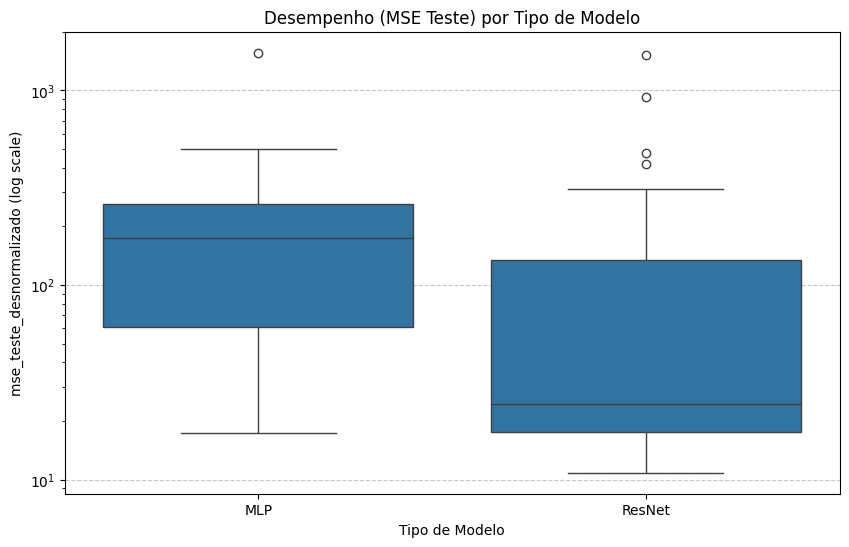

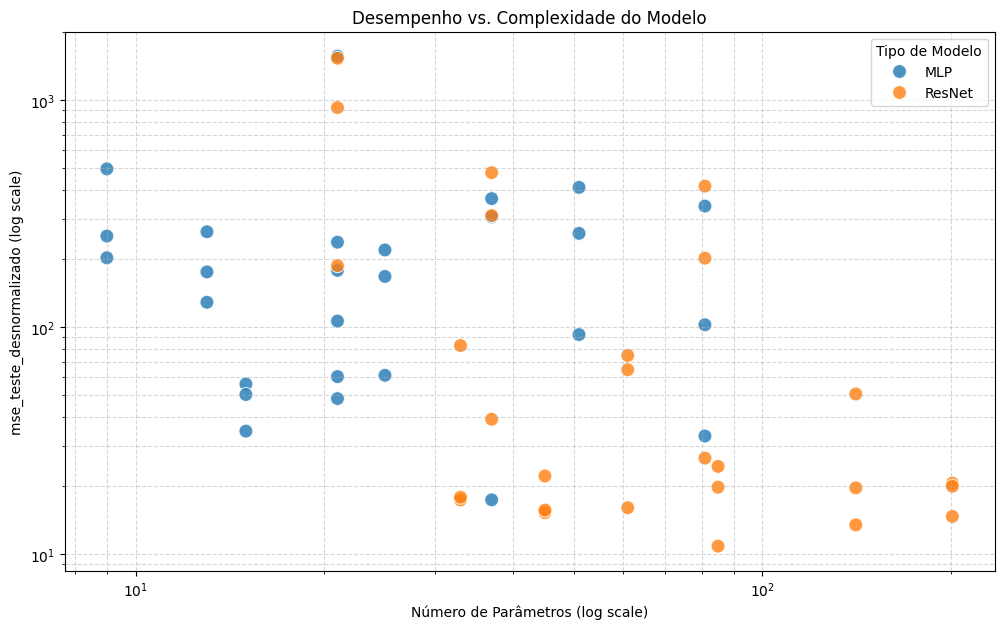

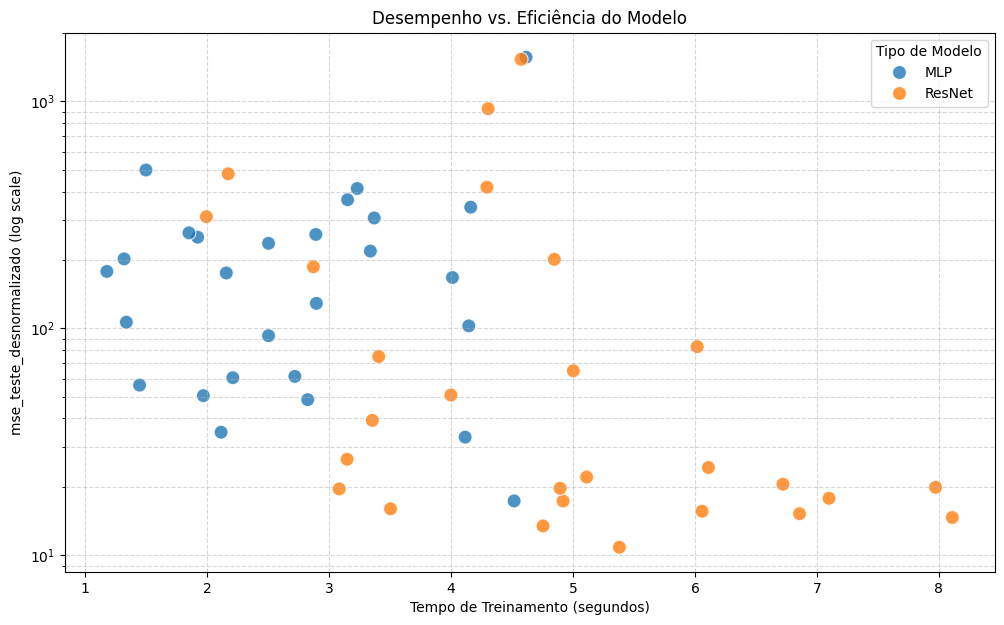

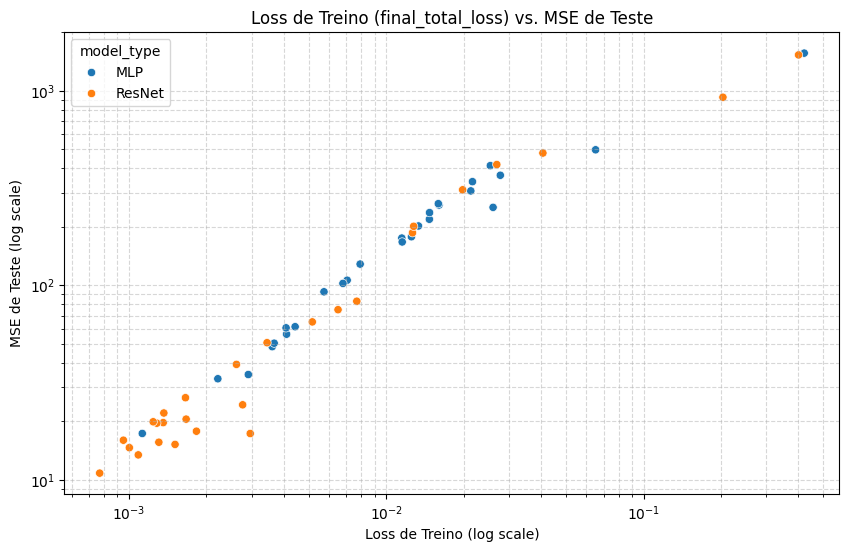

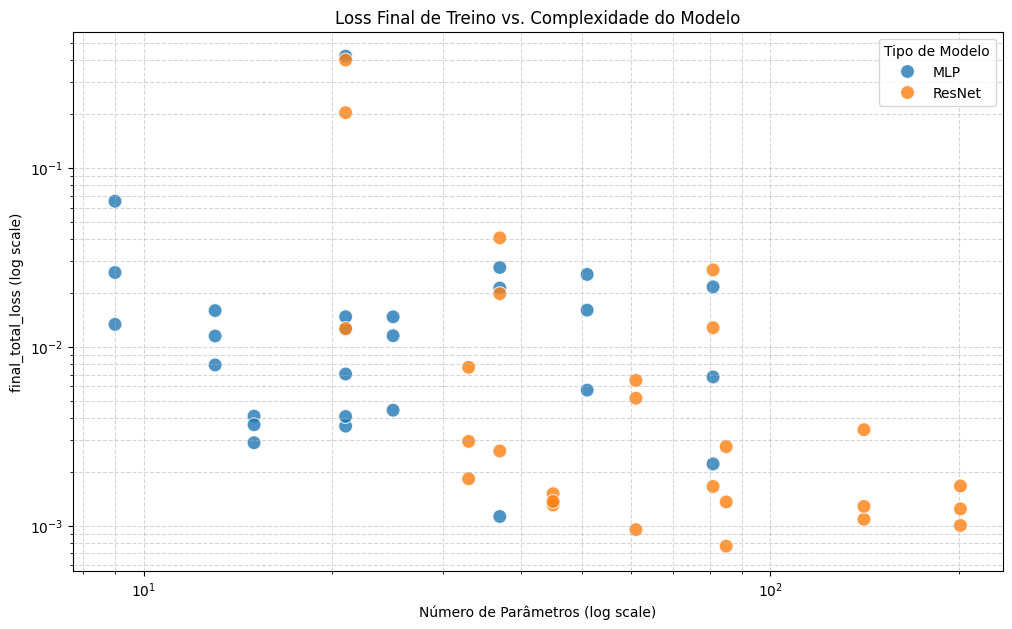

Gerando plots de impacto da arquitetura...


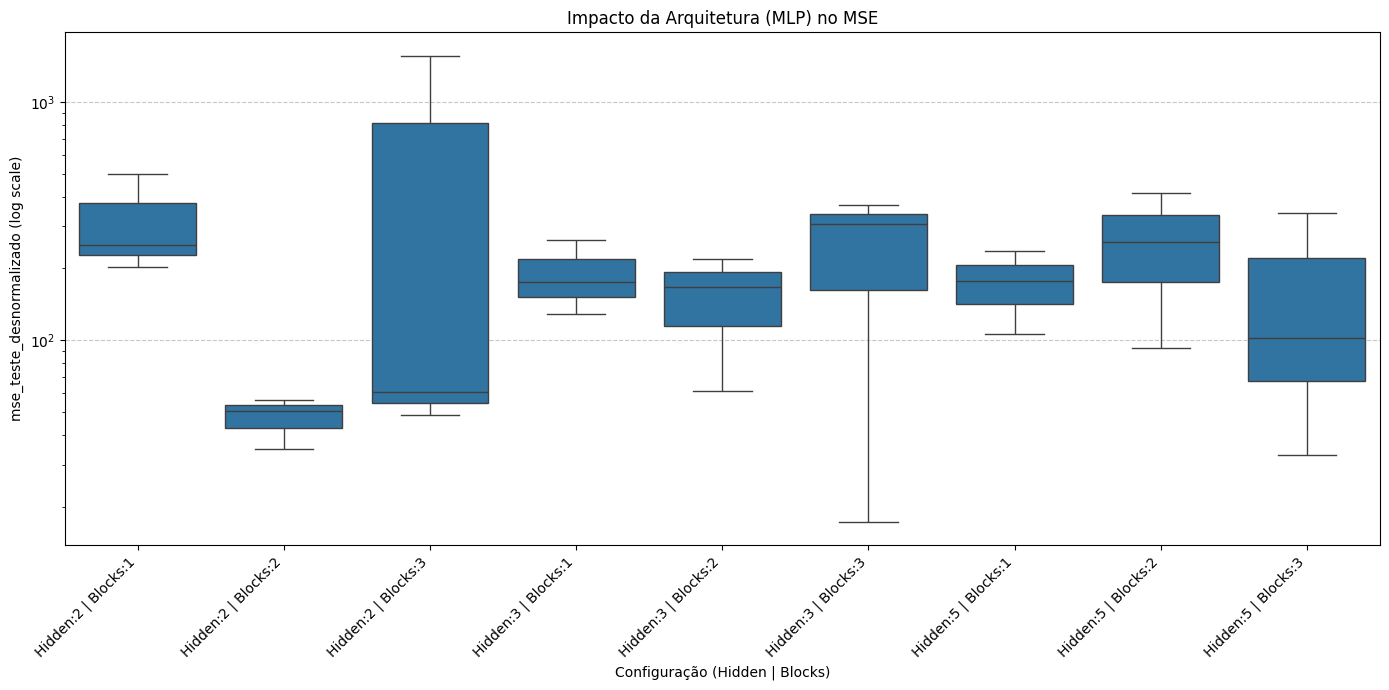

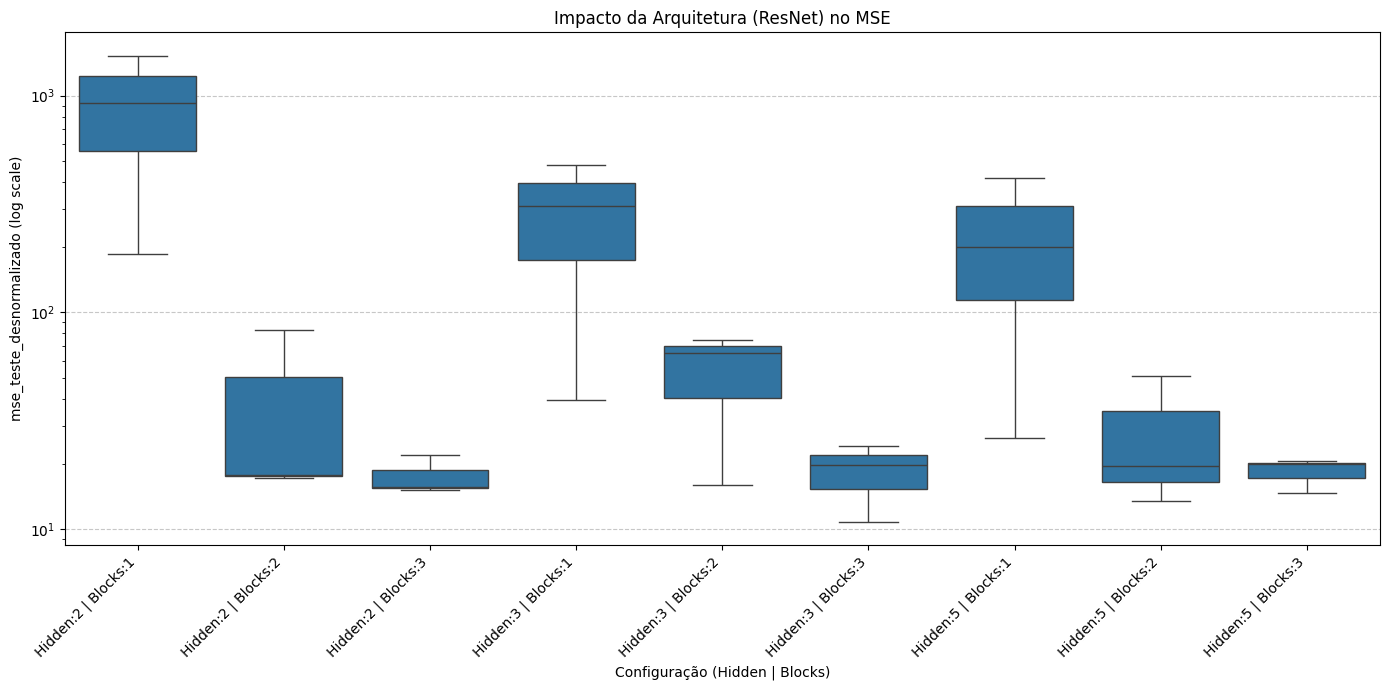

Gerando plot de histórico de loss dos melhores modelos...


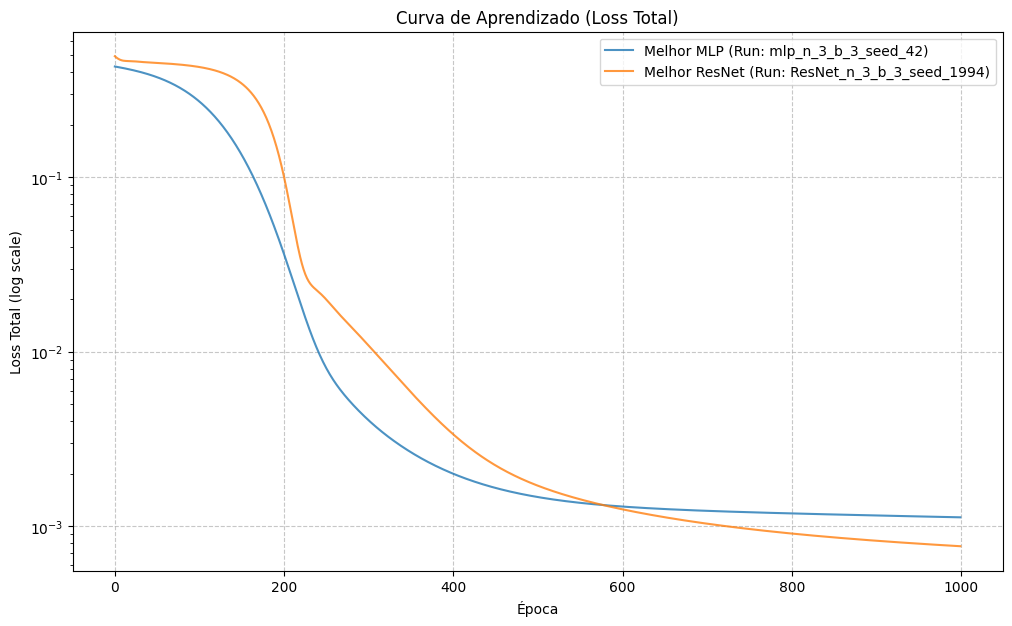

Gerando plot de loss média com incerteza (por seed)...


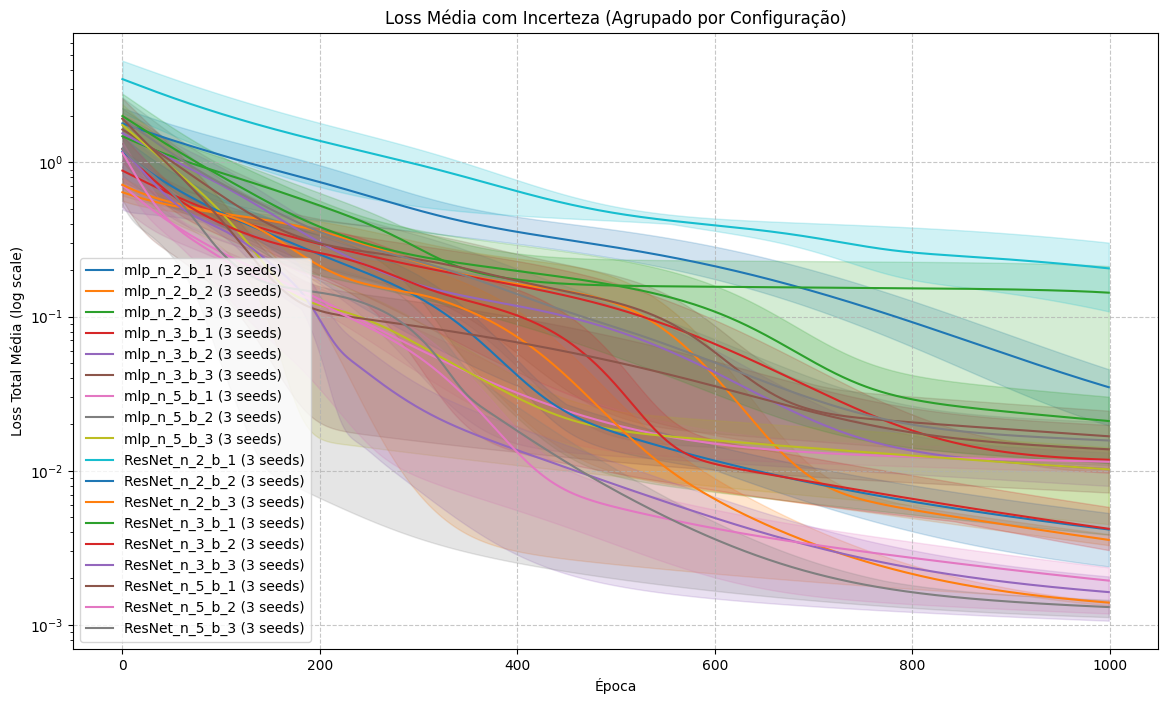

Carregando o MELHOR modelo geral para plot 3D...

Melhor Modelo Encontrado:
  Run ID: ResNet_n_3_b_3_seed_1994
  Tipo:   ResNet
  MSE:    10.838387
  Path:   experimentos_pinn/modelos_salvos/modelo_ResNet_n_3_b_3_seed_1994.pth
Arquitetura recriada e pesos carregados com sucesso.
Gerando plots 3D da solução (Verdadeiro vs. Predito)...


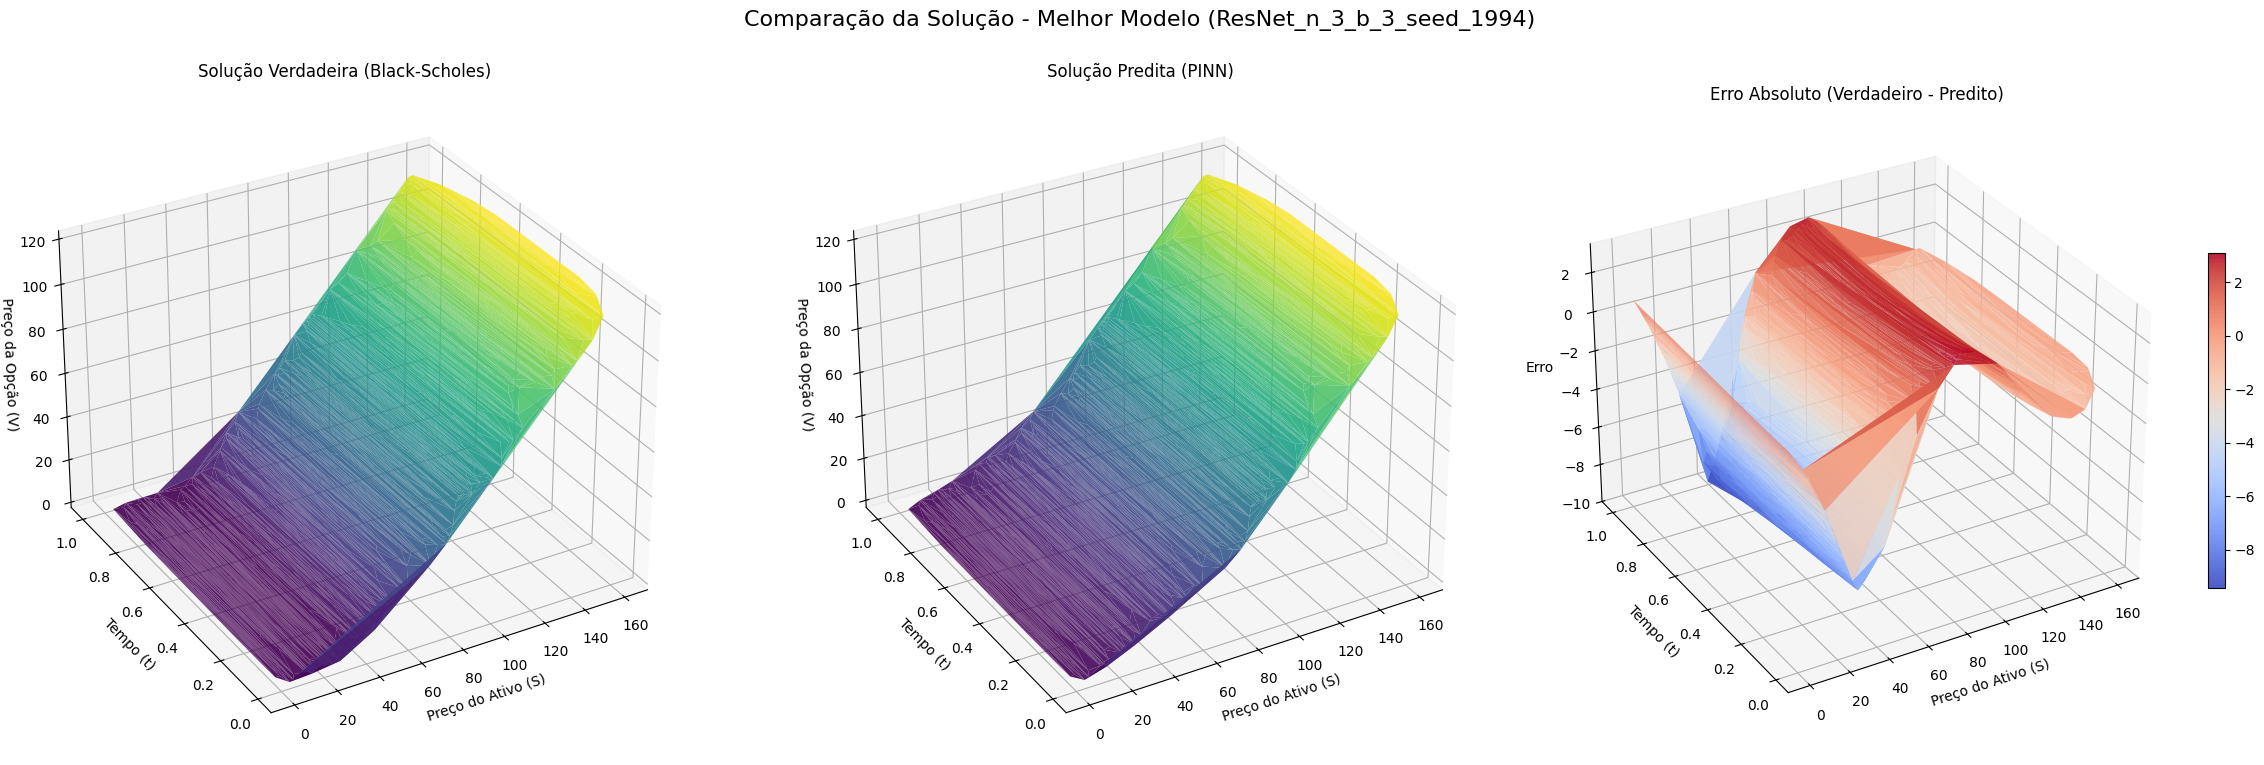


Análise concluída.


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch as tc
import torch.nn as nn
import numpy as np
import json

# --- Importe suas classes ---
# (Precisamos delas para RECONSTRUIR a arquitetura antes de carregar os pesos)
from equation.option_pricing import BlackScholes
from method.nn import MLP, ResNet
from method.hnn import HybridCQN
from method.qnn import QuantumNeuralNetwork

# =============================================================================
# 0. CONFIGURAÇÃO
# =============================================================================

# Diretório onde os resultados foram salvos
RESULTS_DIR = "experimentos_pinn"
SUMMARY_CLASSIC_PATH = os.path.join(RESULTS_DIR, "sumario_classico.csv")
SUMMARY_HYBRID_PATH = os.path.join(RESULTS_DIR, "sumario_hibrido.csv")

# Métrica principal para avaliar os modelos (use a desnormalizada)
MSE_COLUMN = 'mse_teste_desnormalizado'
LOSS_COLUMN = 'final_total_loss' # ou 'mean_last_100_loss'

# Mapeamento de string de ativação para objeto (necessário para recarregar)
activation_map = {
    "Tanh()": nn.Tanh(),
    "ReLU()": nn.ReLU(),
    # Adicione outras ativações se você as usou
}

# Constantes de normalização (as mesmas usadas no treino)
S_max = 160.0
T = 1.0
V_max = 140.0

def load_loss_history(path):
    """Função auxiliar para carregar um histórico de loss de um JSON."""
    try:
        with open(path, 'r') as f:
            history = json.load(f)
        return history
    except Exception as e:
        print(f"AVISO: Não foi possível carregar o histórico de loss: {e}")
        return None

# =============================================================================
# 1. CARREGAR OS DADOS DO SUMÁRIO
# =============================================================================

print("Carregando sumários de resultados...")
all_dfs = []

try:
    df_classic = pd.read_csv(SUMMARY_CLASSIC_PATH)
    all_dfs.append(df_classic)
    print(f"Carregado {len(df_classic)} runs de '{SUMMARY_CLASSIC_PATH}'")
except FileNotFoundError:
    print(f"AVISO: '{SUMMARY_CLASSIC_PATH}' não encontrado. Pulando.")

try:
    df_hybrid = pd.read_csv(SUMMARY_HYBRID_PATH)
    all_dfs.append(df_hybrid)
    print(f"Carregado {len(df_hybrid)} runs de '{SUMMARY_HYBRID_PATH}'")
except FileNotFoundError:
    print(f"AVISO: '{SUMMARY_HYBRID_PATH}' não encontrado. Pulando.")

if not all_dfs:
    print("ERRO: Nenhum arquivo de sumário encontrado. Rode 'run_experiments.py' primeiro.")
    exit()

# Concatena todos os dataframes para análise comparativa
df_all = pd.concat(all_dfs, ignore_index=True)

print("\n--- Sumário dos Experimentos (Amostra) ---")
print(df_all.head())
print("\n")


# =============================================================================
# 2. PLOTS ESTATÍSTICOS (Análise Comparativa)
# =============================================================================

print("Gerando plots estatísticos...")

# --- Plot 2.1: Desempenho (MSE) por Tipo de Modelo ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all, x='model_type', y=MSE_COLUMN)
plt.title('Desempenho (MSE Teste) por Tipo de Modelo')
plt.ylabel(f'{MSE_COLUMN} (log scale)')
plt.xlabel('Tipo de Modelo')
plt.yscale('log')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Plot 2.2: Desempenho (MSE) vs. Complexidade (Parâmetros) ---
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_all, x='num_params', y=MSE_COLUMN, hue='model_type', s=100, alpha=0.8)
plt.title('Desempenho vs. Complexidade do Modelo')
plt.ylabel(f'{MSE_COLUMN} (log scale)')
plt.xlabel('Número de Parâmetros (log scale)')
plt.yscale('log')
plt.xscale('log')
plt.legend(title='Tipo de Modelo')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# --- Plot 2.3: Desempenho (MSE) vs. Eficiência (Tempo) ---
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_all, x='training_time_sec', y=MSE_COLUMN, hue='model_type', s=100, alpha=0.8)
plt.title('Desempenho vs. Eficiência do Modelo')
plt.ylabel(f'{MSE_COLUMN} (log scale)')
plt.xlabel('Tempo de Treinamento (segundos)')
plt.yscale('log')
plt.legend(title='Tipo de Modelo')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# --- Plot 2.4: Loss de Treino vs. MSE de Teste ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_all, x=LOSS_COLUMN, y=MSE_COLUMN, hue='model_type')
plt.title(f'Loss de Treino ({LOSS_COLUMN}) vs. MSE de Teste')
plt.xlabel(f'Loss de Treino (log scale)')
plt.ylabel(f'MSE de Teste (log scale)')
plt.yscale('log')
plt.xscale('log')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# --- Plot 2.5: Loss de Treino vs. Número de Parâmetros ---
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_all, x='num_params', y=LOSS_COLUMN, hue='model_type', s=100, alpha=0.8)
plt.title(f'Loss Final de Treino vs. Complexidade do Modelo')
plt.ylabel(f'{LOSS_COLUMN} (log scale)')
plt.xlabel('Número de Parâmetros (log scale)')
plt.yscale('log')
plt.xscale('log')
plt.legend(title='Tipo de Modelo')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# --- Plot 2.6: Análise de Impacto da Arquitetura por Modelo ---
print("Gerando plots de impacto da arquitetura...")

# Mapeia os parâmetros de arquitetura para cada tipo de modelo
arch_params_map = {
    'MLP':    {'params': ['hidden', 'blocks'], 'labels': ['Hidden', 'Blocks']},
    'ResNet': {'params': ['hidden', 'blocks'], 'labels': ['Hidden', 'Blocks']},
    'QPINN':  {'params': ['n_qubits', 'n_layers'], 'labels': ['Qubits', 'Layers']}
}

for model_type, arch_info in arch_params_map.items():
    df_subset = df_all[df_all['model_type'] == model_type].copy()
    
    # Pula se não houver dados para este tipo de modelo
    if df_subset.empty:
        continue
        
    p1, p2 = arch_info['params']
    l1, l2 = arch_info['labels']
    
    # Pula se as colunas de arquitetura não estiverem no dataframe
    if p1 not in df_subset.columns or p2 not in df_subset.columns:
        print(f"AVISO: Pulando plot de arquitetura para '{model_type}' pois faltam as colunas '{p1}' ou '{p2}'.")
        continue

    # Cria uma coluna de "configuração" para o eixo X
    df_subset['config'] = f'{l1}:' + df_subset[p1].astype(str) + f' | {l2}:' + df_subset[p2].astype(str)
    
    # Ordena para o gráfico ficar bonito
    df_subset = df_subset.sort_values(by=[p1, p2])
    
    plt.figure(figsize=(14, 7))
    sns.boxplot(data=df_subset, x='config', y=MSE_COLUMN)
    plt.title(f'Impacto da Arquitetura ({model_type}) no MSE')
    plt.ylabel(f'{MSE_COLUMN} (log scale)')
    plt.xlabel(f'Configuração ({l1} | {l2})')
    plt.yscale('log')
    plt.xticks(rotation=45, ha="right") # Rotaciona e alinha os labels
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout() # Ajusta o layout para evitar sobreposição de labels
    plt.show()


# =============================================================================
# 3. PLOTS DE HISTÓRICO DE LOSS
# =============================================================================

# --- Plot 3.1: Curvas de Aprendizado (Melhores Modelos) ---
print("Gerando plot de histórico de loss dos melhores modelos...")
plt.figure(figsize=(12, 7))
plt.title('Curva de Aprendizado (Loss Total)')

# Encontra o melhor de cada tipo
model_types = df_all['model_type'].unique()
for m_type in model_types:
    df_subset = df_all[df_all['model_type'] == m_type]
    if df_subset.empty:
        continue
    
    best_run = df_subset.loc[df_subset[MSE_COLUMN].idxmin()]
    history = load_loss_history(best_run['loss_history_path'])
    
    if history and 'Total' in history:
        loss_total = history['Total']
        plt.plot(loss_total, label=f"Melhor {m_type} (Run: {best_run['run_id']})", alpha=0.8)

plt.xlabel('Época')
plt.ylabel('Loss Total (log scale)')
plt.yscale('log')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)
plt.show()


# --- Plot 3.2: Curva de Aprendizado Média com Incerteza (por Seed) ---
print("Gerando plot de loss média com incerteza (por seed)...")
plt.figure(figsize=(14, 8))
plt.title('Loss Média com Incerteza (Agrupado por Configuração)')

config_cols_map = {
    'MLP': ['model_type', 'lr', 'epochs', 'activation', 'hidden', 'blocks'],
    'ResNet': ['model_type', 'lr', 'epochs', 'activation', 'hidden', 'blocks'],
    'QPINN': ['model_type', 'lr', 'epochs', 'n_qubits', 'n_layers']
}

# Itera sobre cada tipo de modelo presente no dataframe
for model_type, config_cols in config_cols_map.items():
    df_subset = df_all[df_all['model_type'] == model_type].copy()
    if df_subset.empty:
        continue

    # Verifica se todas as colunas de config existem para este subset
    if not all(col in df_subset.columns for col in config_cols):
        print(f"AVISO: Pulando análise de incerteza para '{model_type}' pois faltam colunas de configuração.")
        continue
    
    # Agrupa por configurações idênticas (ignorando a seed)
    grouped = df_subset.groupby(config_cols)
    
    for name, group in grouped:
        # Apenas plota se houver mais de uma seed para estatística
        if len(group) > 1:
            all_losses = []
            for idx, row in group.iterrows():
                history = load_loss_history(row['loss_history_path'])
                if history and 'Total' in history:
                    all_losses.append(history['Total'])
            
            if len(all_losses) < 2:
                continue
                
            # Garante que todos os históricos tenham o mesmo tamanho (trunca pelo menor)
            min_len = min(len(h) for h in all_losses)
            loss_array = np.array([h[:min_len] for h in all_losses])
            
            # Calcula a média e os percentis 25 e 75 ao longo das seeds (axis=0)
            mean_loss = np.mean(loss_array, axis=0)
            p25_loss = np.percentile(loss_array, 25, axis=0)
            p75_loss = np.percentile(loss_array, 75, axis=0)
            
            config_label = group.iloc[0]['run_id'].replace(f"_seed_{group.iloc[0]['seed']}", "")
            
            line, = plt.plot(mean_loss, label=f"{config_label} ({len(group)} seeds)")
            plt.fill_between(range(len(mean_loss)), p25_loss, p75_loss, color=line.get_color(), alpha=0.2)

plt.xlabel('Época')
plt.ylabel('Loss Total Média (log scale)')
plt.yscale('log')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)
plt.show()


# =============================================================================
# 4. PLOT DA SOLUÇÃO 3D (Melhor Modelo Geral)
# =============================================================================

print("Carregando o MELHOR modelo geral para plot 3D...")

# --- A. Encontrar o melhor modelo ---
best_run_config = df_all.loc[df_all[MSE_COLUMN].idxmin()]

print(f"\nMelhor Modelo Encontrado:")
print(f"  Run ID: {best_run_config['run_id']}")
print(f"  Tipo:   {best_run_config['model_type']}")
print(f"  MSE:    {best_run_config[MSE_COLUMN]:.6f}")
print(f"  Path:   {best_run_config['model_path']}")

# --- B. Recriar a arquitetura do modelo ---
model_type = best_run_config['model_type']
model = None

try:
    activation_str = best_run_config.get('activation', 'Tanh()')
    activation = activation_map[activation_str]

    if model_type == "MLP":
        model = MLP(hidden=int(best_run_config['hidden']), blocks=int(best_run_config['blocks']), 
                    activation=activation)
    
    elif model_type == "ResNet":
        model = ResNet(hidden=int(best_run_config['hidden']), blocks=int(best_run_config['blocks']), 
                       activation=activation)
    
    elif model_type == "QPINN":
        qnn = QuantumNeuralNetwork(n_qubits=int(best_run_config['n_qubits']), 
                                   n_layers=int(best_run_config['n_layers']))
        model = HybridCQN(classical_pre=None, qnn_block=qnn, classical_post=None)
    
    if model is None:
        raise ValueError(f"Tipo de modelo '{model_type}' não tratado no script de plot.")

    # --- C. Carregar os pesos salvos ---
    model.load_state_dict(tc.load(best_run_config['model_path']))
    model.eval() 
    print("Arquitetura recriada e pesos carregados com sucesso.")

except Exception as e:
    print(f"ERRO AO CARREGAR O MODELO: {e}")
    print("Pulando plot 3D. Verifique se as classes do modelo estão importadas.")
    exit()


# --- D. Gerar dados de teste (com a mesma seed do treino) ---
bse = BlackScholes(eps=1e-10)
data_teste = bse.generate_data(seed=42)

S_test, t_test, V_true = data_teste['domain']
S_test_flat, t_test_flat, V_true_flat = S_test.ravel(), t_test.ravel(), V_true.ravel()

# --- E. Fazer a predição com o modelo carregado ---
_S_test_norm = tc.tensor(S_test / S_max).float()
_t_test_norm = tc.tensor(t_test / T).float()

with tc.no_grad():
    V_pred_norm = model(tc.cat([_S_test_norm, _t_test_norm], dim=1))

V_pred = V_pred_norm.numpy() * V_max
V_pred_flat = V_pred.ravel()

# --- F. Plotar os gráficos 3D ---
print("Gerando plots 3D da solução (Verdadeiro vs. Predito)...")

fig = plt.figure(figsize=(24, 8))
fig.suptitle(f"Comparação da Solução - Melhor Modelo ({best_run_config['run_id']})", fontsize=16)

# Plot 1: Solução Verdadeira
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.set_title('Solução Verdadeira (Black-Scholes)')
ax1.plot_trisurf(S_test_flat, t_test_flat, V_true_flat, cmap='viridis', edgecolor='none', alpha=0.9)
ax1.set_xlabel('Preço do Ativo (S)')
ax1.set_ylabel('Tempo (t)')
ax1.set_zlabel('Preço da Opção (V)')
ax1.view_init(30, -120)

# Plot 2: Solução Predita (PINN)
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.set_title('Solução Predita (PINN)')
ax2.plot_trisurf(S_test_flat, t_test_flat, V_pred_flat, cmap='viridis', edgecolor='none', alpha=0.9)
ax2.set_xlabel('Preço do Ativo (S)')
ax2.set_ylabel('Tempo (t)')
ax2.set_zlabel('Preço da Opção (V)')
ax2.view_init(30, -120)

# Plot 3: Erro (Verdadeiro - Predito)
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
erro = V_true_flat - V_pred_flat
ax3.set_title('Erro Absoluto (Verdadeiro - Predito)')
sc = ax3.plot_trisurf(S_test_flat, t_test_flat, erro, cmap='coolwarm', edgecolor='none', alpha=0.9)
fig.colorbar(sc, ax=ax3, shrink=0.5)
ax3.set_xlabel('Preço do Ativo (S)')
ax3.set_ylabel('Tempo (t)')
ax3.set_zlabel('Erro')
ax3.view_init(30, -120)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\nAnálise concluída.")

